# Fun City Rankings

Which cities in the world are the most fun?

A lot depends on this question.

When tourists decide where to travel, their top question is "will I have fun?". When planners invest in a city, their goal is to build a place where residents will enjoy their lives. Fun is at the center of a virtuous circle. Happy cities bring companies looking to hire happy workers.

### Project Report
[Download Project Report (PDF)](./Fun_City_Rank_Report_002.pdf)

### Survey Data

The [Time Out Index](www.timeout.com/things-to-do/time-out-index) is one attempt to rank the world's best cities. It is a survey developed by [Time Out](www.timeout.com/about/time-out-group) designed to compare life in the greatest cities around the world. The 2019 Time Out Index surveyed 34,000 people about life in their city. They then ranked the 48 best cities in the world.

The top 5 ranked cities were:
1.	New York
2.	Melbourne
3.	Chicago
4.	London
5.	Los Angeles

The bottom 5 ranked cities were:
44.	Marseille
45.	Bangkok
46.	Kuala Lumpur
47.	Beijing
48.	Istanbul

## Foursquare Location Data

But surveying 34,000 people is an expensive project. The results are also prone to interpretation and strong cultural biases that cannot be completely scrubbed from the data.

Can location data from [Foursquare](www.foursquare.com) be used instead to provide a cheaper and more objective "Fun Rank"?

This project examines that question. The analysis pulls categorized venue location data from Foursquare to generate a "Fun City Ranking". The analysis is then compared to the original "Time Out Index" to see if pure data analytics is a substitute for more personal surveys.

## Methodology

The Foursquare Venue Categories are grouped together into "Top Level Fun" types. For example:

* **Watch** - includes: Circus, Movie Theatre, Concert Hall, Stadium

* **Visit** - includes: Exhibitions, Memorial Sites, Botanical Garden, Scenic Lookout

* **Strive** - includes: Fitness Center, Bike Trail, Fishing Spot, Golf Course

* **Amuse** - includes: Casino, Pool Hall, Racecourse, Theme Park

* **Indulge** - includes: Desert Shop, Creperie, Candy Store, Vineyard

* **Relax** - includes: Coffee Shop, Massage Studio, Sauna, Resort

* **Party** - includes: Bar, Nightclub, Music Venue, Dance Club

The Fun Rank of each city is calculated by comparing both the number and variety of fun venues accessible to tourists. Hence a city that has hundreds of casinos but nothing else will score low overall.

Those cities that scores well in each "Top Level Fun" category – the cities that offer the most ways to _Watch_ and _Visit_ and _Strive_ and _Amuse_ and _Indulge_ and _Relax_ and _Party_ – will be ranked among the world’s most fun cities.

### Details

This project will:

1. Use the Foursquare Venue Search API to collect city venue data
   * Data is collected for the same Top-48 cities identified in the Time Out Index
   * The search covers venues fitting the 7 “Top Level Fun” categories (including 120+ Foursquare Categories and Sub-Categories)
   * The search radius covers 2 km around each downtown city center
   * The maximum of 50 venues per query [City x Category] is collected


2. Calculate a "Fun Rank" for each city
   * Parse the Foursquare data to calculate the number of accessible fun venues
   * Group the individual categories by “Top Level Fun” categories
   * Sort each city by each Top-Level Fun category and allocate points (this normalizes the results so that a city with 2 stadiums won’t lose out to a city with 3 salsa clubs)
   * Sum the points given to each city
   * Sort and rank all the cities


3. Compare the “Fun Rank” with the “Time Out Index 2019”
   * Create a Scatter Plot comparing the two results
   * Run a regression to fit the Fun Rank against the Time Out Index
   * Discuss sources of discrepancies


4. Map Fun Venues in each City
   * Use the Folium library to map venues in select cities
   * Color code the venues by Top-Level Fun category


5. Use the Foursquare Venue Photos API
   * Collect outdoor city photos taken from nearby intersections
   * Collect city photos taken at historical city sites


6. Prepare a blog posting discussing the project findings
   * Include rankings, charts, maps, and photos

## Step 1: Load Dependencies

In [1]:
import pandas as pd
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

import numpy as np

In [2]:
# Import library to handle Foursquare REST requests
import requests

In [344]:
pip install seaborn

Note: you may need to restart the kernel to use updated packages.


In [345]:
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
pip install folium

Note: you may need to restart the kernel to use updated packages.


In [4]:
# Import Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# Import k-means from clustering stage
from sklearn.cluster import KMeans

# Import Map Rendering Library
import folium

In [238]:
pip install geocoder

Note: you may need to restart the kernel to use updated packages.


In [239]:
# Import the Geocoder Library to lookup Latitude and Longitude of Toronto Neighborhoods
import geocoder

In [ ]:
# Have the user manually enter the Foursquare Credentials so they are not stored in the raw Jupyter notebook
# Clear Cell Outputs after running!!!
FOURSQUARE_CLIENT_ID = input("[1/3] Enter your FourSquare Client ID:")
FOURSQUARE_CLIENT_SECRET = input("[2/3] Enter your FourSquare Client Secret:")
FOURSQUARE_VERSION = input("[3/3] Enter your FourSquare Version Number:")

## Step 2: Set Project Parameters

In [289]:
# Define the Top Level Fun Categories
funCategories = pd.DataFrame({'CategoryGroup': [
    'Watch',
    'Visit',
    'Strive',
    'Amuse',
    'Indulge',
    'Relax',
    'Party',
    'Location']})

funCategories['CategoryGroupID'] = funCategories.reset_index().index

print( funCategories.shape )
funCategories

(8, 2)


,CategoryGroup,CategoryGroupID
0,Watch,0
1,Visit,1
2,Strive,2
3,Amuse,3
4,Indulge,4
5,Relax,5
6,Party,6
7,Location,7


In [6]:
# Define the dataframe columns for the Categories
columnsCategories = ['CategorySortID', 'Category', 'CategoryID', 'CategoryGroup'] 

# Instantiate the dataframe
categories = pd.DataFrame(columns=columnsCategories)

In [290]:
# Read in the "Top-Level Fun" Categories
categories = pd.read_csv("Top Level Fun Categories 001.csv")

# Merge together the Top Level Fun Categories
categories = pd.merge(categories, funCategories, on=['CategoryGroup'], how='inner')

print( categories.shape )
categories.head()

(122, 5)


,CategorySortID,Category,CategoryID,CategoryGroup,CategoryGroupID
0,1,Arcade,4bf58dd8d48988d1e1931735,Amuse,3
1,2,Bowling Alley,4bf58dd8d48988d1e4931735,Amuse,3
2,3,Casino,4bf58dd8d48988d17c941735,Amuse,3
3,4,Go Kart Track,52e81612bcbc57f1066b79ea,Amuse,3
4,5,Karaoke Box,5744ccdfe4b0c0459246b4bb,Amuse,3


In [291]:
# Count the number of Foursquare Categories in each Top-Level Fun Category
groupCategoryCount = categories.groupby(['CategoryGroup'], as_index=True)['CategoryID'].count()

# Concatenate the Foursquare Categories in each Top-Level Fun Category
groupCategoryNames = categories.groupby(['CategoryGroup'], as_index=True)['Category'].apply(', '.join).reset_index()

# Merge together the final Grouped Categories
groupCategories = pd.merge(groupCategoryCount, groupCategoryNames, on=['CategoryGroup'], how='inner')

# Summarize the Venue Categories that will be collected from the Foursquare search API
print( groupCategories.shape )
groupCategories.head(8)

# Note that the 'Location' CategoryGroup is only used to collect city photos

(8, 3)


,CategoryGroup,CategoryID,Category
0,Amuse,13,"Arcade, Bowling Alley, Casino, Go Kart Track, ..."
1,Indulge,7,"Creperie, Dessert Shop, Donut Shop, Vineyard, ..."
2,Location,2,"Post Office, Intersection"
3,Party,24,"Music Venue, Salsa Club, Beach Bar, Beer Bar, ..."
4,Relax,5,"Café, Coffee Shop, Massage Studio, Sauna / Ste..."
5,Strive,32,"Badminton Court, Baseball Field, Basketball Co..."
6,Visit,33,"Amphitheater, Aquarium, Art Gallery, Exhibit, ..."
7,Watch,6,"Circus, Comedy Club, Concert Hall, Movie Theat..."


In [348]:
# Define the dataframe columns for the Target Cities
columnsCities = ['TimeOutRank', 'City', 'State', 'Country', 'CityURL'] 

# Instantiate the dataframe
cities = pd.DataFrame(columns=columnsCities)

In [349]:
# Read in the "Target Cities" - note that these are the same 48 cities as those in the "Time Out Index 2019"
cities = pd.read_csv("Target Cities 001.csv")

print( cities.shape )
cities.head()

(48, 5)


,TimeOutRank,City,State,Country,CityURL
0,1,New York,NY,USA,New+York%2c+NY%2c+USA
1,2,Melbourne,Victoria,Australia,Melbourne%2c+Victoria%2c+Australia
2,3,Chicago,IL,USA,Chicago%2c+IL%2c+USA
3,4,London,NaN,England,London%2c+England
4,5,Los Angeles,CA,USA,Los+Angeles%2c+CA%2c+USA


In [294]:
# Create a Cross-Join so that all Venues are collected from all Cities across all Categories

categories['key'] = 0
cities['key'] = 0
queries = categories.merge(cities, how='left', on = 'key')

categories.drop('key',1, inplace=True)
cities.drop('key',1, inplace=True)
queries.drop('key',1, inplace=True)

print( queries.shape )
queries.head()

(5856, 10)


,CategorySortID,Category,CategoryID,CategoryGroup,CategoryGroupID,CityRank,City,State,Country,CityURL
0,1,Arcade,4bf58dd8d48988d1e1931735,Amuse,3,1,New York,NY,USA,New+York%2c+NY%2c+USA
1,1,Arcade,4bf58dd8d48988d1e1931735,Amuse,3,2,Melbourne,Victoria,Australia,Melbourne%2c+Victoria%2c+Australia
2,1,Arcade,4bf58dd8d48988d1e1931735,Amuse,3,3,Chicago,IL,USA,Chicago%2c+IL%2c+USA
3,1,Arcade,4bf58dd8d48988d1e1931735,Amuse,3,4,London,NaN,England,London%2c+England
4,1,Arcade,4bf58dd8d48988d1e1931735,Amuse,3,5,Los Angeles,CA,USA,Los+Angeles%2c+CA%2c+USA


In [295]:
# Create a function to collect nearby Venues from a Category from the downtown center of a City

def getCityCategoryVenues(listCity, listCityURL, listCategory, listCategoryID, radius=2000, limit=100):

    # Count the number of queries being processed
    countQueries = 0

    venues_list=[]
    for city, cityURL, category, categoryID in zip(listCity, listCityURL,listCategory, listCategoryID):
        
        # Update the user on which neighborhood is being explored
        countQueries += 1
        print('Searching Venues of Category [{}] near downtown City [{}].'.format(category, city))

        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/search?near={}&categoryId={}&radius={}&limit={}&client_id={}&client_secret={}&v={}'.format(
            city, 
            categoryID, 
            radius, 
            limit, 
            FOURSQUARE_CLIENT_ID, 
            FOURSQUARE_CLIENT_SECRET, 
            FOURSQUARE_VERSION
            )

        # Continue if Error with processing the GET request
        try:
            # make the GET request
            results = requests.get(url, timeout=10).json()["response"]["venues"]

            # return only relevant information for each nearby venue
            venues_list.append([(
                city, 
                category, 
                categoryID, 
                v['name'], 
                v['id'], 
                v['location']['lat'], 
                v['location']['lng'],  
                v['categories'][0]['name']) for v in results])
        except: 
            pass        

    returnVenues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    returnVenues.columns = [
                  'City', 
                  'Category', 
                  'CategoryID', 
                  'Venue', 
                  'VenueID', 
                  'Latitude', 
                  'Longitude', 
                  'VenueCategory']
    
    return(returnVenues)

In [296]:
# Limit the number of neighborhoods that can be explored
MAX_QUERIES = 2

# Select which neighborhoods to explore
selectQueries = queries.copy()

# Call Foursquare to explore nearby venues in each Neighborhood
venues = getCityCategoryVenues(
                               listCity=selectQueries.head(MAX_QUERIES)['City'],
                               listCityURL=selectQueries.head(MAX_QUERIES)['CityURL'],
                               listCategory=selectQueries.head(MAX_QUERIES)['Category'],
                               listCategoryID=selectQueries.head(MAX_QUERIES)['CategoryID']
                              )

print('Finished looking up Venues.')

Searching Venues of Category [Arcade] near downtown City [New York].
Searching Venues of Category [Arcade] near downtown City [Melbourne].
Finished looking up Venues.


In [297]:
venues.head()

,City,Category,CategoryID,Venue,VenueID,Latitude,Longitude,VenueCategory
0,New York,Arcade,4bf58dd8d48988d1e1931735,BrainXcape,58153f0538fa212749790b30,40.740792,-73.993513,General Entertainment
1,New York,Arcade,4bf58dd8d48988d1e1931735,5th ave. arcade inc.,42869100f964a52018231fe3,40.746602,-73.981801,Arcade
2,New York,Arcade,4bf58dd8d48988d1e1931735,Jump Into The Light,5908d8ceaa6c9535c5e4c2cb,40.721741,-73.988103,Arcade
3,New York,Arcade,4bf58dd8d48988d1e1931735,Barcade,518a71ab498e430858000827,40.744417,-73.994423,Bar
4,New York,Arcade,4bf58dd8d48988d1e1931735,Standard Creator Lounge,59eaa298002f4c707b103051,40.729486,-74.000105,Lounge


In [298]:
# Define the dataframe columns for the City-Category Venues
columnsVenues = ['City', 'Category', 'CategoryID', 'Venue', 'VenueID', 'Latitude', 'Longitude', 'VenueCategory'] 

# Instantiate the dataframe
venues = pd.DataFrame(columns=columnsVenues)

# Try reading in the venues from earlier - necessary as it takes a very long time to load and parse venue data
venues = pd.read_excel(open('City Category Venues 001.xlsx','rb'), sheet_name='default')

print( venues.shape )
venues.head()

(71283, 8)


,City,Category,CategoryID,Venue,VenueID,Latitude,Longitude,VenueCategory
0,New York,Arcade,4bf58dd8d48988d1e1931735,BrainXcape,58153f0538fa212749790b30,40.740792,-73.993513,General Entertainment
1,New York,Arcade,4bf58dd8d48988d1e1931735,5th ave. arcade inc.,42869100f964a52018231fe3,40.746602,-73.981801,Arcade
2,New York,Arcade,4bf58dd8d48988d1e1931735,Barcade,518a71ab498e430858000827,40.744417,-73.994423,Bar
3,New York,Arcade,4bf58dd8d48988d1e1931735,Zoltar,506b7815e4b08b16970c1292,40.728618,-73.987827,Arcade
4,New York,Arcade,4bf58dd8d48988d1e1931735,Dave & Buster's,44510be3f964a520a0321fe3,40.756774,-73.988540,Arcade


In [299]:
# Join the 'Top Level Fun' Categories (CategoryGroup) and drop the superfluous VenueCategory
venues.drop('VenueCategory', 1, inplace=True)
venues = venues.merge(categories, how='inner', on = ['Category', 'CategoryID'])

print( venues.shape )
venues.head()

(71283, 10)


,City,Category,CategoryID,Venue,VenueID,Latitude,Longitude,CategorySortID,CategoryGroup,CategoryGroupID
0,New York,Arcade,4bf58dd8d48988d1e1931735,BrainXcape,58153f0538fa212749790b30,40.740792,-73.993513,1,Amuse,3
1,New York,Arcade,4bf58dd8d48988d1e1931735,5th ave. arcade inc.,42869100f964a52018231fe3,40.746602,-73.981801,1,Amuse,3
2,New York,Arcade,4bf58dd8d48988d1e1931735,Barcade,518a71ab498e430858000827,40.744417,-73.994423,1,Amuse,3
3,New York,Arcade,4bf58dd8d48988d1e1931735,Zoltar,506b7815e4b08b16970c1292,40.728618,-73.987827,1,Amuse,3
4,New York,Arcade,4bf58dd8d48988d1e1931735,Dave & Buster's,44510be3f964a520a0321fe3,40.756774,-73.988540,1,Amuse,3


In [300]:
# Group by City and Rank the number of Fun Categories
rankCityCategory = venues.groupby(['CategoryGroup','City'], as_index=False)['CategoryID'].count()

print( rankCityCategory.shape )
rankCityCategory.head(10)

(384, 3)


,CategoryGroup,City,CategoryID
0,Amuse,Abu Dhabi,39
1,Amuse,Bangkok,89
2,Amuse,Barcelona,108
3,Amuse,Beijing,20
4,Amuse,Berlin,57
5,Amuse,Birmingham,30
6,Amuse,Boston,34
7,Amuse,Buenos Aires,61
8,Amuse,Cape Town,25
9,Amuse,Chicago,22


In [301]:
# Sort each Fun Category by the number of venues in each City - most 'fun' City in each Fun Category sorted to the top
rankCityCategory.sort_values(['CategoryGroup','CategoryID'], ascending=[True,False], inplace=True)
rankCityCategory.reset_index(inplace=True, drop=True)

print( rankCityCategory.shape )
rankCityCategory.head(10)

(384, 3)


,CategoryGroup,City,CategoryID
0,Amuse,Singapore,272
1,Amuse,Istanbul,223
2,Amuse,São Paulo,138
3,Amuse,Tokyo,136
4,Amuse,Kuala Lumpur,131
5,Amuse,Vienna,131
6,Amuse,Moscow,118
7,Amuse,Shanghai,110
8,Amuse,Barcelona,108
9,Amuse,Melbourne,108


In [302]:
# For each Fun CategoryGroup, add points to each City by the number of nearby fun venues (Top City = 48 points / Bottom City = 1 point)
# Note that allocating Points by Fun CategoryGroup helps to normalize the results so that CategoryGroups can be compared across cities
# Also add a star-rating by Fun Category Group. The city offering the most fun in each category is allocated 5-stars with the least fun city getting next to 0-stars

for funCategory in groupCategories['CategoryGroup']:
    
    # Allocate up to 48-points to each city within each Category
    rankCityCategory.loc[rankCityCategory['CategoryGroup'] == funCategory, 'Points'] = list( range( len(rankCityCategory.loc[rankCityCategory['CategoryGroup'] == funCategory]), 0, -1) )
    
    # Rescale 'points' to 'stars' with the most fun city receiving the maximum of 5-stars
    rankCityCategory.loc[rankCityCategory['CategoryGroup'] == funCategory, 'Stars'] = 5.0 * rankCityCategory.loc[rankCityCategory['CategoryGroup'] == funCategory, 'Points'] / len(rankCityCategory.loc[rankCityCategory['CategoryGroup'] == funCategory])
    
print( rankCityCategory.shape )
rankCityCategory.head()

(384, 5)


,CategoryGroup,City,CategoryID,Points,Stars
0,Amuse,Singapore,272,48.0,5.000000
1,Amuse,Istanbul,223,47.0,4.895833
2,Amuse,São Paulo,138,46.0,4.791667
3,Amuse,Tokyo,136,45.0,4.687500
4,Amuse,Kuala Lumpur,131,44.0,4.583333


In [303]:
# Sum the total number of Stars each City recieved then sort by Most Fun City
sortCityCategory = rankCityCategory.groupby(['City'], as_index=False)['Points'].sum()
sortCityCategory.sort_values(['Points'], ascending=[False], inplace=True)
sortCityCategory.reset_index(inplace=True, drop=True)

print( sortCityCategory.shape )
sortCityCategory.head()

(48, 2)


,City,Points
0,New York,351.0
1,Istanbul,336.0
2,Singapore,326.0
3,Tokyo,325.0
4,London,303.0


In [406]:
# Create a function to collect photos from a list of Venues

def getVenuePhotos(listVenue, listVenueID, limit=2):

    # Count the number of queries being processed
    countQueries = 0

    venues_list=[]
    for venue, venueID in zip(listVenue, listVenueID):
        
        # Update the user on which Venue is being explored
        countQueries += 1
        print('Searching Photos of Venue [{}].'.format(venue))

        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/{}/photos?limit={}&client_id={}&client_secret={}&v={}'.format(
            venueID, 
            limit, 
            FOURSQUARE_CLIENT_ID, 
            FOURSQUARE_CLIENT_SECRET, 
            FOURSQUARE_VERSION
            )

        # Continue if Error with processing the GET request
        try:
            # make the GET request
            results = requests.get(url, timeout=10).json()["response"]["photos"]["items"]

            # return only relevant information for each venue
            venues_list.append([(
                v['prefix'],
                v['suffix'],
                v['width'],
                v['height']) for v in results])
        except: 
            pass        

    returnVenues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    returnVenues.columns = [
                  'Prefix', 
                  'Suffix', 
                  'Width', 
                  'Height']
    
    return(returnVenues)

In [409]:
# Limit the number of Venues that can be explored
MAX_QUERIES = 2

# Select which Venues to explore
selectVenues = venues[(venues['City'] == 'Chicago') & (venues['Category'] == 'Historic Site')]

# Call Foursquare to collect Photos nearby each Venue
photos = getVenuePhotos(
                        listVenue=selectVenues.head(MAX_QUERIES)['Venue'],
                        listVenueID=selectVenues.head(MAX_QUERIES)['VenueID']
                        )

print('Finished looking up Photos.')
photos.head()

Searching Photos of Venue [Chicago Ghost Investigations].
Searching Photos of Venue [Willie Dixon's Blues Heaven Foundation, Historic Site of Chess Records].
Finished looking up Photos.


,Prefix,Suffix,Width,Height
0,https://fastly.4sqi.net/img/general/,/84950627_kSxWmKGWTqWcYID91xYalPDLiJ9iK5PmRHOP...,720,720
1,https://fastly.4sqi.net/img/general/,/KeG_shX_RvgljBL3p2vaeP7WeIGK58ZhPcL9usiFgdg.jpg,540,629
2,https://fastly.4sqi.net/img/general/,/pK52KQmyz4bFLETLaZt5rJVLdjPYpyhByrRbE92wBeA.jpg,404,720


## Calculated Fun City Rankings

In [304]:
# Sorted from 'Most Fun City' down to 'Least Fun City'
sortCityCategory

,City,Points
0,New York,351.0
1,Istanbul,336.0
2,Singapore,326.0
3,Tokyo,325.0
4,London,303.0
5,Kuala Lumpur,301.0
6,Vienna,295.0
7,Madrid,290.0
8,Sydney,289.0
9,Seattle,289.0


In [364]:
# Visualize the Fun Locations by City
cityShortName = 'New York'
cityLongName = 'New York, NY'

# Get the Venues in the City
# Select a sample of 10% of venues to show on the Map
mapData = venues[(venues['City'] == cityShortName) & (venues['Latitude'].notnull()) & (venues['Longitude'].notnull())].sample(frac=0.1)

# Get the City Location
cityLocation = geocoder.arcgis(cityLongName)

print('The City: {} is located at [{},{}] and has {} fun venues'.format(cityLongName, cityLocation.latlng[0], cityLocation.latlng[1], mapData.shape))

The City: New York, NY is located at [40.71455000000003,-74.00713999999994] and has (274, 10) fun venues


In [360]:
mapData.head()

,City,Category,CategoryID,Venue,VenueID,Latitude,Longitude,CategorySortID,CategoryGroup,CategoryGroupID
0,New York,Arcade,4bf58dd8d48988d1e1931735,BrainXcape,58153f0538fa212749790b30,40.740792,-73.993513,1,Amuse,3
1,New York,Arcade,4bf58dd8d48988d1e1931735,5th ave. arcade inc.,42869100f964a52018231fe3,40.746602,-73.981801,1,Amuse,3
2,New York,Arcade,4bf58dd8d48988d1e1931735,Barcade,518a71ab498e430858000827,40.744417,-73.994423,1,Amuse,3
3,New York,Arcade,4bf58dd8d48988d1e1931735,Zoltar,506b7815e4b08b16970c1292,40.728618,-73.987827,1,Amuse,3
4,New York,Arcade,4bf58dd8d48988d1e1931735,Dave & Buster's,44510be3f964a520a0321fe3,40.756774,-73.988540,1,Amuse,3


In [365]:
# Map the City

# Create a map
mapCity = folium.Map(location=[cityLocation.latlng[0], cityLocation.latlng[1]], zoom_start=13)

# Set the color scheme for the Top Level Fun Categories
x = np.arange( len(funCategories) )
ys = [i + x + (i*x)**2 for i in range( len(funCategories) )]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for latitude, longitude, venue, category, group, color in zip(mapData['Latitude'], mapData['Longitude'], mapData['Venue'], mapData['Category'], mapData['CategoryGroup'], mapData['CategoryGroupID']):
    try:
        idColor = int(color)
    except:
        idColor = 0
    label = folium.Popup(str(group) + ' [' + str(category) + ']: ' + str(venue), parse_html=True)
    folium.CircleMarker(
        [latitude, longitude],
        radius=5,
        popup=label,
        color=rainbow[idColor-1],
        fill=True,
        fill_color=rainbow[idColor-1],
        fill_opacity=0.7
        ).add_to(mapCity)
       
mapCity

### New York Static Map of Fun Locations [TimeOut Rank = 1 / Fun City Rank = 1]
![New York Static Map of Fun Locations](New_York_Fun_Locations_001.png "New York Static Map of Fun Locations")

In [319]:
# Visualize the Fun Locations by City
cityShortName = 'Istanbul'
cityLongName = 'Istanbul, Turkey'

# Get the Venues in the City
# Select a sample of 10% of venues to show on the Map
mapData = venues[(venues['City'] == cityShortName) & (venues['Latitude'].notnull()) & (venues['Longitude'].notnull())].sample(frac=0.1)

# Get the City Location
cityLocation = geocoder.arcgis(cityLongName)

print('The City: {} is located at [{},{}] and has {} fun venues'.format(cityLongName, cityLocation.latlng[0], cityLocation.latlng[1], mapData.shape))

The City: Istanbul, Turkey is located at [41.01384000000007,28.94966000000005] and has (267, 10) fun venues


In [320]:
# Map the City

# Create a map
mapCity = folium.Map(location=[cityLocation.latlng[0], cityLocation.latlng[1]], zoom_start=13)

# Set the color scheme for the Top Level Fun Categories
x = np.arange( len(funCategories) )
ys = [i + x + (i*x)**2 for i in range( len(funCategories) )]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for latitude, longitude, venue, category, group, color in zip(mapData['Latitude'], mapData['Longitude'], mapData['Venue'], mapData['Category'], mapData['CategoryGroup'], mapData['CategoryGroupID']):
    try:
        idColor = int(color)
    except:
        idColor = 0
    label = folium.Popup(str(group) + ' [' + str(category) + ']: ' + str(venue), parse_html=True)
    folium.CircleMarker(
        [latitude, longitude],
        radius=5,
        popup=label,
        color=rainbow[idColor-1],
        fill=True,
        fill_color=rainbow[idColor-1],
        fill_opacity=0.7
        ).add_to(mapCity)
       
mapCity

### Istanbul Static Map of Fun Locations [TimeOut Rank = 48 / Fun City Rank = 2]
![Istanbul Static Map of Fun Locations](Istanbul_Fun_Locations_001.png "New York Static Map of Fun Locations")

In [321]:
# Visualize the Fun Locations by City
cityShortName = 'Melbourne'
cityLongName = 'Melbourne, Victoria, Australia'

# Get the Venues in the City
# Select a sample of 10% of venues to show on the Map
mapData = venues[(venues['City'] == cityShortName) & (venues['Latitude'].notnull()) & (venues['Longitude'].notnull())].sample(frac=0.1)

# Get the City Location
cityLocation = geocoder.arcgis(cityLongName)

print('The City: {} is located at [{},{}] and has {} fun venues'.format(cityLongName, cityLocation.latlng[0], cityLocation.latlng[1], mapData.shape))

The City: Melbourne, Victoria, Australia is located at [-37.817489999999964,144.96715000000006] and has (195, 10) fun venues


In [322]:
# Map the City

# Create a map
mapCity = folium.Map(location=[cityLocation.latlng[0], cityLocation.latlng[1]], zoom_start=13)

# Set the color scheme for the Top Level Fun Categories
x = np.arange( len(funCategories) )
ys = [i + x + (i*x)**2 for i in range( len(funCategories) )]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for latitude, longitude, venue, category, group, color in zip(mapData['Latitude'], mapData['Longitude'], mapData['Venue'], mapData['Category'], mapData['CategoryGroup'], mapData['CategoryGroupID']):
    try:
        idColor = int(color)
    except:
        idColor = 0
    label = folium.Popup(str(group) + ' [' + str(category) + ']: ' + str(venue), parse_html=True)
    folium.CircleMarker(
        [latitude, longitude],
        radius=5,
        popup=label,
        color=rainbow[idColor-1],
        fill=True,
        fill_color=rainbow[idColor-1],
        fill_opacity=0.7
        ).add_to(mapCity)
       
mapCity

### Melbourne Static Map of Fun Locations [TimeOut Rank = 2 / Fun City Rank = 10]
![Melbourne Static Map of Fun Locations](Melbourne_Fun_Locations_001.png "Melbourne Static Map of Fun Locations")

In [323]:
# Visualize the Fun Locations by City
cityShortName = 'Chicago'
cityLongName = 'Chicago, IL, USA'

# Get the Venues in the City
# Select a sample of 10% of venues to show on the Map
mapData = venues[(venues['City'] == cityShortName) & (venues['Latitude'].notnull()) & (venues['Longitude'].notnull())].sample(frac=0.1)

# Get the City Location
cityLocation = geocoder.arcgis(cityLongName)

print('The City: {} is located at [{},{}] and has {} fun venues'.format(cityLongName, cityLocation.latlng[0], cityLocation.latlng[1], mapData.shape))

The City: Chicago, IL, USA is located at [41.884250000000065,-87.63244999999995] and has (91, 10) fun venues


In [324]:
# Map the City

# Create a map
mapCity = folium.Map(location=[cityLocation.latlng[0], cityLocation.latlng[1]], zoom_start=13)

# Set the color scheme for the Top Level Fun Categories
x = np.arange( len(funCategories) )
ys = [i + x + (i*x)**2 for i in range( len(funCategories) )]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for latitude, longitude, venue, category, group, color in zip(mapData['Latitude'], mapData['Longitude'], mapData['Venue'], mapData['Category'], mapData['CategoryGroup'], mapData['CategoryGroupID']):
    try:
        idColor = int(color)
    except:
        idColor = 0
    label = folium.Popup(str(group) + ' [' + str(category) + ']: ' + str(venue), parse_html=True)
    folium.CircleMarker(
        [latitude, longitude],
        radius=5,
        popup=label,
        color=rainbow[idColor-1],
        fill=True,
        fill_color=rainbow[idColor-1],
        fill_opacity=0.7
        ).add_to(mapCity)
       
mapCity

### Chicago Static Map of Fun Locations [TimeOut Rank = 3 / Fun City Rank = 38]
![Chicago Static Map of Fun Locations](Chicago_Fun_Locations_001.png "Chicago Static Map of Fun Locations")

In [326]:
# Visualize the Fun Locations by City
cityShortName = 'Glasgow'
cityLongName = 'Glasgow, Scotland'

# Get the Venues in the City
# Select a sample of 10% of venues to show on the Map
mapData = venues[(venues['City'] == cityShortName) & (venues['Latitude'].notnull()) & (venues['Longitude'].notnull())].sample(frac=0.1)

# Get the City Location
cityLocation = geocoder.arcgis(cityLongName)

print('The City: {} is located at [{},{}] and has {} fun venues'.format(cityLongName, cityLocation.latlng[0], cityLocation.latlng[1], mapData.shape))

The City: Glasgow, Scotland is located at [55.857830000000035,-4.242509999999925] and has (97, 10) fun venues


In [327]:
# Map the City

# Create a map
mapCity = folium.Map(location=[cityLocation.latlng[0], cityLocation.latlng[1]], zoom_start=13)

# Set the color scheme for the Top Level Fun Categories
x = np.arange( len(funCategories) )
ys = [i + x + (i*x)**2 for i in range( len(funCategories) )]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for latitude, longitude, venue, category, group, color in zip(mapData['Latitude'], mapData['Longitude'], mapData['Venue'], mapData['Category'], mapData['CategoryGroup'], mapData['CategoryGroupID']):
    try:
        idColor = int(color)
    except:
        idColor = 0
    label = folium.Popup(str(group) + ' [' + str(category) + ']: ' + str(venue), parse_html=True)
    folium.CircleMarker(
        [latitude, longitude],
        radius=5,
        popup=label,
        color=rainbow[idColor-1],
        fill=True,
        fill_color=rainbow[idColor-1],
        fill_opacity=0.7
        ).add_to(mapCity)
       
mapCity

### Glasgow Static Map of Fun Locations [TimeOut Rank = 8 / Fun City Rank = 34]
![Glasgow Static Map of Fun Locations](Glasgow_Fun_Locations_001.png "Glasgow Static Map of Fun Locations")

In [329]:
# Visualize the Fun Locations by City
cityShortName = 'Kuala Lumpur'
cityLongName = 'Kuala Lumpur, Malaysia'

# Get the Venues in the City
# Select a sample of 10% of venues to show on the Map
mapData = venues[(venues['City'] == cityShortName) & (venues['Latitude'].notnull()) & (venues['Longitude'].notnull())].sample(frac=0.1)

# Get the City Location
cityLocation = geocoder.arcgis(cityLongName)

print('The City: {} is located at [{},{}] and has {} fun venues'.format(cityLongName, cityLocation.latlng[0], cityLocation.latlng[1], mapData.shape))

The City: Kuala Lumpur, Malaysia is located at [3.147890000000075,101.69405000000006] and has (189, 10) fun venues


In [330]:
# Map the City

# Create a map
mapCity = folium.Map(location=[cityLocation.latlng[0], cityLocation.latlng[1]], zoom_start=13)

# Set the color scheme for the Top Level Fun Categories
x = np.arange( len(funCategories) )
ys = [i + x + (i*x)**2 for i in range( len(funCategories) )]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for latitude, longitude, venue, category, group, color in zip(mapData['Latitude'], mapData['Longitude'], mapData['Venue'], mapData['Category'], mapData['CategoryGroup'], mapData['CategoryGroupID']):
    try:
        idColor = int(color)
    except:
        idColor = 0
    label = folium.Popup(str(group) + ' [' + str(category) + ']: ' + str(venue), parse_html=True)
    folium.CircleMarker(
        [latitude, longitude],
        radius=5,
        popup=label,
        color=rainbow[idColor-1],
        fill=True,
        fill_color=rainbow[idColor-1],
        fill_opacity=0.7
        ).add_to(mapCity)
       
mapCity

### Kuala Lumpur Static Map of Fun Locations [TimeOut Rank = 46 / Fun City Rank = 8]
![Kuala Lumpur Static Map of Fun Locations](Kuala_Lumpur_Fun_Locations_001.png "Kuala Lumpur Static Map of Fun Locations")

In [355]:
# Visualize the Fun Locations by City
cityShortName = 'Las Vegas'
cityLongName = 'Las Vegas, NV, USA'

# Get the Venues in the City
# Select a sample of 10% of venues to show on the Map
mapData = venues[(venues['City'] == cityShortName) & (venues['Latitude'].notnull()) & (venues['Longitude'].notnull())].sample(frac=0.1)

# Get the City Location
cityLocation = geocoder.arcgis(cityLongName)

print('The City: {} is located at [{},{}] and has {} fun venues'.format(cityLongName, cityLocation.latlng[0], cityLocation.latlng[1], mapData.shape))

The City: Las Vegas, NV, USA is located at [36.17193000000003,-115.14000999999996] and has (66, 10) fun venues


In [356]:
# Map the City

# Create a map
mapCity = folium.Map(location=[cityLocation.latlng[0], cityLocation.latlng[1]], zoom_start=13)

# Set the color scheme for the Top Level Fun Categories
x = np.arange( len(funCategories) )
ys = [i + x + (i*x)**2 for i in range( len(funCategories) )]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for latitude, longitude, venue, category, group, color in zip(mapData['Latitude'], mapData['Longitude'], mapData['Venue'], mapData['Category'], mapData['CategoryGroup'], mapData['CategoryGroupID']):
    try:
        idColor = int(color)
    except:
        idColor = 0
    label = folium.Popup(str(group) + ' [' + str(category) + ']: ' + str(venue), parse_html=True)
    folium.CircleMarker(
        [latitude, longitude],
        radius=5,
        popup=label,
        color=rainbow[idColor-1],
        fill=True,
        fill_color=rainbow[idColor-1],
        fill_opacity=0.7
        ).add_to(mapCity)
       
mapCity

### Las Vegas Static Map of Fun Locations [TimeOut Rank = 13 / Fun City Rank = 45]
![Las Vegas Static Map of Fun Locations](Las_Vegas_Fun_Locations_001.png "Las Vegas Static Map of Fun Locations")

In [366]:
# Visualize the Fun Locations by City
cityShortName = 'Paris'
cityLongName = 'Paris, France'

# Get the Venues in the City
# Select a sample of 10% of venues to show on the Map
mapData = venues[(venues['City'] == cityShortName) & (venues['Latitude'].notnull()) & (venues['Longitude'].notnull())].sample(frac=0.1)

# Get the City Location
cityLocation = geocoder.arcgis(cityLongName)

print('The City: {} is located at [{},{}] and has {} fun venues'.format(cityLongName, cityLocation.latlng[0], cityLocation.latlng[1], mapData.shape))

The City: Paris, France is located at [48.85717000000005,2.3414000000000215] and has (158, 10) fun venues


In [367]:
# Map the City

# Create a map
mapCity = folium.Map(location=[cityLocation.latlng[0], cityLocation.latlng[1]], zoom_start=13)

# Set the color scheme for the Top Level Fun Categories
x = np.arange( len(funCategories) )
ys = [i + x + (i*x)**2 for i in range( len(funCategories) )]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for latitude, longitude, venue, category, group, color in zip(mapData['Latitude'], mapData['Longitude'], mapData['Venue'], mapData['Category'], mapData['CategoryGroup'], mapData['CategoryGroupID']):
    try:
        idColor = int(color)
    except:
        idColor = 0
    label = folium.Popup(str(group) + ' [' + str(category) + ']: ' + str(venue), parse_html=True)
    folium.CircleMarker(
        [latitude, longitude],
        radius=5,
        popup=label,
        color=rainbow[idColor-1],
        fill=True,
        fill_color=rainbow[idColor-1],
        fill_opacity=0.7
        ).add_to(mapCity)
       
mapCity

### Paris Static Map of Fun Locations [TimeOut Rank = 9 / Fun City Rank = 23]
![Paris Static Map of Fun Locations](Paris_Fun_Locations_001.png "Paris Static Map of Fun Locations")

## Compare "Time Out Index" and "Fun City Rank"

In [350]:
# The "Time Out Index" rankings is held in the original 'cities' table
cities.head()

,TimeOutRank,City,State,Country,CityURL
0,1,New York,NY,USA,New+York%2c+NY%2c+USA
1,2,Melbourne,Victoria,Australia,Melbourne%2c+Victoria%2c+Australia
2,3,Chicago,IL,USA,Chicago%2c+IL%2c+USA
3,4,London,NaN,England,London%2c+England
4,5,Los Angeles,CA,USA,Los+Angeles%2c+CA%2c+USA


In [351]:
# Fix the calculated 'Fun City Rank'
sortCityCategory['FunCityRank'] = sortCityCategory.reset_index().index + 1
sortCityCategory.head()

,City,Points,FunCityRank
0,New York,351.0,1
1,Istanbul,336.0,2
2,Singapore,326.0,3
3,Tokyo,325.0,4
4,London,303.0,5


In [352]:
# Join the Fun City Rank to the original list of Cities
cities = pd.merge(cities, sortCityCategory, on=['City'], how='inner')

print( cities.shape )
cities.head()

(47, 7)


,TimeOutRank,City,State,Country,CityURL,Points,FunCityRank
0,1,New York,NY,USA,New+York%2c+NY%2c+USA,351.0,1
1,2,Melbourne,Victoria,Australia,Melbourne%2c+Victoria%2c+Australia,272.0,14
2,3,Chicago,IL,USA,Chicago%2c+IL%2c+USA,86.0,39
3,4,London,NaN,England,London%2c+England,303.0,5
4,5,Los Angeles,CA,USA,Los+Angeles%2c+CA%2c+USA,208.0,26


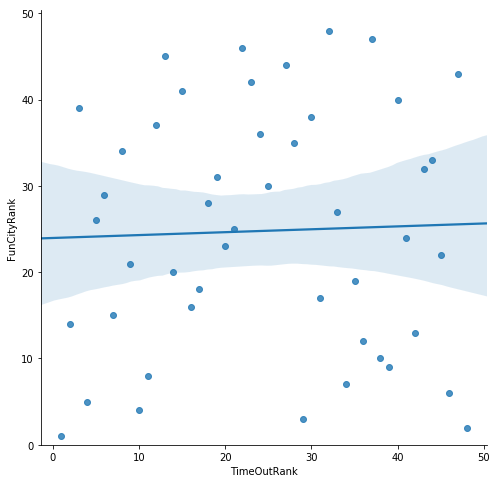

In [413]:
# Check whether the Time Out Index survey results correlate with the calculated Fun City Rank
g = sns.regplot(x="TimeOutRank", y="FunCityRank", data=cities)
plt.ylim(0,)

g.figure.set_size_inches(8, 8)
sns.despine()

### Static Correlation: Time Out Rank vs Fun City Rank
![Time Out Rank vs Fun City Rank](FunCityRank_vs_TimeOutRank_Regression_001.png "Time Out Rank vs Fun City Rank")

In [354]:
# Calculate the Correlation between the two ranking systems
cities[["TimeOutRank", "FunCityRank"]].corr()

,TimeOutRank,FunCityRank
TimeOutRank,1.000000,0.033966
FunCityRank,0.033966,1.000000


## Conclusion
There is no correlation between the 'Time Out Rank 2019' survey results and this location-based 'Fun City Rank' calculation.